In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import calendar

from sklearn.cross_validation import train_test_split,KFold,ShuffleSplit
from sklearn.metrics import roc_auc_score,accuracy_score,average_precision_score,roc_curve,auc,precision_recall_curve,log_loss
from sklearn.grid_search import GridSearchCV

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

import xgboost as xgb
from scipy import interp
from sklearn.externals import joblib


from jllib import xval,feat_imp

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
INPUT_FILE_02 = 'C:\Users\liuleo\Documents\REPO\AGitHUB\TEST_DATA\home\jliu\TEST\FPF_1702.csv'
INPUT_FILE_03 = 'C:\Users\liuleo\Documents\REPO\AGitHUB\TEST_DATA\home\jliu\TEST\FPF_1703.csv'
#INPUT_FILE_05 = 'C:\Users\liuleo\Documents\REPO\AGitHUB\TEST_DATA\home\jliu\TEST\FPF_1705_onlyC.csv'
FEAT_IMP_OUTPUT = 'C:\Users\liuleo\Documents\REPO\AGitHUB\TEST_DATA\home\jliu\TEST\FPF_020305_FEAT_CAMP3.csv'
MODEL_PKL_OUTPUT = 'C:\Users\liuleo\Documents\REPO\AGitHUB\TEST_DATA\home\jliu\TEST\FPF_020305.pkl'
APPLY_DATASET = 'C:\Users\liuleo\Documents\REPO\AGitHUB\TEST_DATA\home\jliu\TEST\FPF_1705_onlyC.csv'

In [3]:
%time fpf_1702 = pd.read_csv(INPUT_FILE_02, sep='|')
%time fpf_1703 = pd.read_csv(INPUT_FILE_03, sep='|')
#%time fpf_1705 = pd.read_csv(INPUT_FILE_05, sep='|')

Wall time: 5.25 s
Wall time: 1.98 s


In [4]:
print fpf_1702.cifno.nunique()
print fpf_1702.shape
fpf_1702 = fpf_1702[fpf_1702['AVGD']>=1000000].reset_index(drop=True)
print fpf_1702.cifno.nunique()
print fpf_1702.shape

19163
(19163, 692)
14524
(14524, 692)


In [5]:
print fpf_1703.cifno.nunique()
print fpf_1703.shape
fpf_1703 = fpf_1703[fpf_1703['AVGD']>=1000000].reset_index(drop=True)
print fpf_1703.cifno.nunique()
print fpf_1703.shape

9695
(9695, 692)
5374
(5374, 692)


In [6]:
target_map = {1:0,
              0:1}

fpf_1702['fpf_target'] = fpf_1702['fpf_target'].map(target_map)


fpf_1703['fpf_target'] = fpf_1703['fpf_target'].map(target_map)

In [7]:
fpf_dataset = pd.concat([fpf_1702, fpf_1703]).reset_index(drop=True) #,fpf_1705
#fpf_dataset = fpf_1705.copy()

In [8]:
print fpf_dataset.shape
print fpf_dataset.cifno.nunique()
print fpf_dataset.drop_duplicates(['cifno','fpf_target']).cifno.nunique()
print fpf_dataset.drop_duplicates(['cifno','fpf_target']).fpf_target.sum()
print fpf_dataset.drop_duplicates(['cifno','fpf_target']).fpf_target.mean()

(19898, 692)
19898
19898
4395
0.220876469997


# Change data type to reduce memory

In [9]:
UINT8_COLS = ['WEST','fpf_target','nb_accts_sd','health_freq_db_edc','leisure_hobby_freq_db_edc','luxury_freq_db_edc',
              'household_freq_db_edc','offus_freq_db_edc','services_freq_db_edc','daily_life_freq_db_edc','vehicle_freq_db_edc',
              'T1_bank_ph','T2_bank_ph','T3_bank_ph','T4_bank_ph','T5_bank_ph','T6_bank_ph','T7_bank_ph','T8_bank_ph',
              'T9_bank_ph','T10_bank_ph','T11_bank_ph','T12_bank_ph','T13_bank_ph','T14_bank_ph','T15_bank_ph','T16_bank_ph',
              'T17_bank_ph','T18_bank_ph','TOTPH_bank_ph','TOT_SAVING_bank_ph','CREDITCARD_freq_trxout','EDUCATION_freq_trxout',
              'INSURANCE_freq_trxout','INTERBANKTRANSFER_freq_trxout','INTRABANKTRANSFER_freq_trxout','LEASING_freq_trxout',
              'MEDIA_freq_trxout','PDAM_freq_trxout','PERSONALLOAN_freq_trxout','PLN_freq_trxout','PULSA_freq_trxout',
              'TICKET_freq_trxout','TVCABLE_freq_trxout','ZAKAT_freq_trxout','TSO_LOS','TSO_AGE','TSO_DEPENDANT']

INT8_COLS = ['delta_days_lm', 'max_vintage_3mth', 'max_vintage_6mth', 'min_vintage_3mth', 'min_vintage_6mth', 'delta_vintage_3mth',
            'delta_vintage_6mth', 'maxdt_range_cnts', 'mindt_range_cnts','age_tier','year_addr','year_rel','year_work','depend_nb',
            'nb_alop_cc','nb_classic_cc','nb_gold_cc','nb_platinum_cc','nb_signature_cc','total_nb_cc','nb_prioritas_dc',
            'nb_silver_dc','nb_gold_dc','nb_platinum_dc','nb_others_dc','total_nb_dc','travel_freq_db_edc','maxdb_num_day',
            'maxdb_num_uni_weekday','maxcd_num_uni_weekday','maxdb_day_1_10','maxdb_day_11_20','maxdb_day_21_up','maxcd_num_day',
             'maxcd_day_1_10','maxcd_day_11_20','maxcd_day_21_up','delta_range_lm','TSO_LOCATION_01.BBD',
             'TSO_CATEGORY_01.TOP GUN', 'TSO_CATEGORY_02.STRIKER','TSO_CATEGORY_03.PLAYMAKER','TSO_CATEGORY_04.DEFENDER',
             'TSO_EDUCATION_01.S2','TSO_EDUCATION_02.S1','TSO_EDUCATION_03.AKADEMI','TSO_EDUCATION_04.SLTA','TSO_GENDER_02.MALE',
             'TSO_MARITAL_STATUS_02.MAR'] 

INT16_COLS = ['sum_freq_lm3_db_edc','sum_freq_lm6_db_edc','freq_lm_lm3_diff_db_edc','freq_lm3_lm6_diff_db_edc',
              'max_freq_lm3_db_edc','min_freq_lm3_db_edc', 'maxcd_num','maxdb_num','saving_acct_vint_l_bank_ph',
              'saving_acct_vint_f_bank_ph','saving_acct_delta_bank_ph','all_acct_vint_l_bank_ph','all_acct_vint_f_bank_ph',
              'all_acct_delta_bank_ph','TSO_DB_LM','TSO_DB_LM2','TSO_DB_LM3','TSO_DB_CONTACTED_LM','TSO_DB_CONTACTED_LM2',
              'TSO_DB_CONTACTED_LM3','TSO_CALL_LM','TSO_CALL_LM2','TSO_CALL_LM3','TSO_CALL_CONTACTED_LM','TSO_CALL_CONTACTED_LM2',
              'TSO_CALL_CONTACTED_LM3','TSO_MJK_CASES_LM2','TSO_MJK_CASES_LM','TSO_MJK_CASES_LM3','TSO_MPK_CASES_LM',
              'TSO_MPK_CASES_LM2','TSO_MPK_CASES_LM3','TSO_MHS_CASES_LM','TSO_MHS_CASES_LM2','TSO_MHS_CASES_LM3',
              'TSO_MHP_CASES_LM2','TSO_MHP_CASES_LM3','TSO_MHP_CASES_LM','TSO_MSP_CASES_LM2','TSO_MSP_CASES_LM3',
             'TSO_MSP_CASES_LM','TSO_OTHER_CASES_LM','TSO_OTHER_CASES_LM2','TSO_OTHER_CASES_LM3','TSO_TOTAL_CASES_LM',
             'TSO_TOTAL_CASES_LM2','TSO_TOTAL_CASES_LM3']

UINT16_COLS = ['ib_freq_trxout','mb_freq_trxout','branch_freq_trxout','nm_atm_freq_trxout','m_atm_freq_trxout','mcm_freq_trxout',
              'chnl_others_freq_trxout','sum_purchase_freq_trxout','date_org_vintage','sum_TSO_DB','sum_TSO_DB_contacted',
               'sum_TSO_CALL_contacted','sum_TSO_CALL','sum_TSO_MJK_MHL_CASES_3m','sum_TSO_CASES_3m']

INT64_COLS = ['max_bal_3mth', 'max_bal_6mth', 'min_bal_3mth', 'min_bal_6mth', 'eom_3mth', 'eom_6mth', 'sum_end_bal', 'MED_lm', 
              'QT1_lm', 'QT3_lm', 'D20_lm', 'EOM_lm', 'NOD_lm','MED_lm2','QT1_lm2', 'QT3_lm2','MED_lm3', 'QT1_lm3', 'QT3_lm3', 
              'one_max_delta_bal_3mth','d20_3mth','vol_income']
INT8_COLS_FLAG = [col for col in fpf_dataset if 'flag' in col]

DUMMIFIED_COLS = ['intuser_fg', 'mbluser_fg', 'prior_fg', 'rsdnt_fg', 'weekday_','gender_id','occp_id','houstyp_id','marital_id',
                  'cusedu_id','empinds_id','CALL_START_hour_']

INT8_COLS_DUM = [col for col in fpf_dataset for dum in DUMMIFIED_COLS if dum in col]

INT8_COLS_ALL = INT8_COLS + INT8_COLS_FLAG + INT8_COLS_DUM

In [10]:
print 'change data types to reduce memory usage'
for col in UINT8_COLS:
    fpf_dataset[col] = fpf_dataset[col].astype(np.uint8)
    
for col in INT8_COLS_ALL:
    fpf_dataset[col] = fpf_dataset[col].astype(np.int8)
    
for col in INT16_COLS:
    fpf_dataset[col] = fpf_dataset[col].astype(np.int16)

for col in UINT16_COLS:
    fpf_dataset[col] = fpf_dataset[col].astype(np.uint16)

for col in INT64_COLS:
    fpf_dataset[col] = fpf_dataset[col].astype(np.int64)

change data types to reduce memory usage


# Start Modeling

In [11]:
WEEKDAY_COLS = [col for col in fpf_dataset if 'weekday_' in col]
fpf_dataset.drop(WEEKDAY_COLS, axis=1, inplace=True)

fpf_dataset.drop(['AGENT_ID'], axis=1, inplace=True)
fpf_dataset.drop(['payroll_flag','payroll_tableflag'],axis=1, inplace=True) #,'CIFNO_loan'

In [12]:
tso_cols = [x for x in fpf_dataset if 'TSO' in x]
hour_cols = [x for x in fpf_dataset if 'hour' in x]
DROP_COLS = tso_cols + hour_cols

fpf_dataset.drop(DROP_COLS, axis=1, inplace=True)

In [13]:
ALL_TARGETS = ['fpf_target']
IDS = ['cifno']
feature_columns = [col for col in fpf_dataset if col not in IDS and col not in ALL_TARGETS]
feature_columns = np.concatenate([IDS, feature_columns])

In [14]:
print(ALL_TARGETS)

for target in ALL_TARGETS:
    print("target number %s"%target)
    print(fpf_dataset[target].sum())
    print("target proportion %s"%target)
    print(fpf_dataset[target].mean())

train, test = train_test_split(fpf_dataset,train_size=0.7)

print('Train data has %i rows and %i columns'%(train.shape[0], train.shape[1]))
print('Test data has %i rows and %i columns'%(test.shape[0], test.shape[1]))

COLS_TO_DROP = ALL_TARGETS + IDS  

X_train = train.drop(COLS_TO_DROP,axis=1)
X_test = test.drop(COLS_TO_DROP,axis=1)

['fpf_target']
target number fpf_target
4395
target proportion fpf_target
0.220876469997
Train data has 13928 rows and 580 columns
Test data has 5970 rows and 580 columns


# XVAL model

# Handling numeric features

In [15]:
numeric_cols = [
    'EOMD_loan','EOM_lm_loan','EOMD','MX_lm_loan','delta_max_min_bal_lm','MX_lm','LOANALL_bank_ph','EOM_lm','MND','SDEV_lm2',
    'sum_end_bal','D20_lm_loan','min_db_lm3_trxnet','SDEV_lm','D20_lm','delta_max_min_bal_lm_loan','min_purchase_amt_lm6_trxout',
    'min_cd_lm3_trxnet','min_db_lm6_trxnet','min_trxout_lm3_trxout','SDEV_lm3','min_bal_3mth','QT3_lm3','d20_3mth_loan',
    'sum_cd_trxnet','sum_db_lm6_trxnet','MND_loan','QT3_lm2_loan','MN_lm_loan','delta_avg_bal_t1_t2','bill_payment_trxout',
    'ratio_delta_avg_bal_t1_t2','MED_lm3','QT1_lm2','avg_lm3_loan','MN_lm','maxcd_amt','avg_lm2_loan','AVGD'
]

def process_money(x):
    x = x / 1000
    if x / 1000 == 0:
        return x
    else:
        if x > 0:
            flg = 1
        else:
            flg = -1
        x = abs(x)
        ds = int(np.log10(x))
        x = round(x / pow(10, ds - 2)) * pow(10, ds - 2)
        return x * flg
    
def process_numeric(df):
    for col in numeric_cols:
        df[col] = df[col].apply(lambda x : process_money(x))
    return df

# Handling float features

In [16]:
float_cols = [  
    'transfer_to_mandiri_per_trxout','INTRABANKTRANSFER_amt_per_trxout','avg_delta_days_3mth'
]

def process_float(df):
    for col in float_cols:
        df[col] = df[col].apply(lambda x : round(x, 3))
    return df

In [17]:
TOP_FEATS = ['EOMD_loan_nearest_a','EOMD_loan_C_a','EOMD_loan_nearest','EOMD_loan','EOMD_nearest','EOM_lm_loan_nearest_a',
'MX_lm_loan_nearest_a','EOM_lm_loan','T16_bank_ph','EOM_lm_loan_nearest','maxcd_num_day','MND_nearest',
'EOM_lm_nearest','EOMD_C','occp_id_PNS','EOMD_C_a','MND_C','EOMD','MX_lm_loan_nearest','EOMD_nearest_a',
'num_cd_trxnet','MX_lm_loan','tot_loan_t-1','maxcd_num','EOM_lm_C','EOM_lm_nearest_a','min_cd_lm3_trxnet',
'loan_recent_inc_count','tot_loan_t-2','delta_max_min_bal_lm','MX_lm','LOANALL_bank_ph','MND_C_a','T3_bank_ph',         
'EOM_lm','MND','SDEV_lm2','delta_days_lm','sum_end_bal','TOT_UNDEBIT_SAVING','transfer_to_mandiri_per_trxout',
'ratio_undebit_saving','D20_lm_loan','min_db_lm3_trxnet','SDEV_lm','AVG_lm_nearest_a','MN_lm_C','AVGD_loan_C',
'min_db_lm6_trxnet','saving_acct_delta_bank_ph','D20_lm','bill_payment_freq_trxout',
'INTRABANKTRANSFER_amt_per_trxout','delta_max_min_bal_lm_loan','all_acct_delta_bank_ph',
'delta_undebit_saving','eom_6mth_C_a','TOT_SAVING_bank_ph','min_trxout_lm3_trxout','D20_lm_nearest_a',
'tot_loan_delta_t_t-2','min_purchase_amt_lm6_trxout','TOTPH_bank_ph','SDEV_lm3','delta_vintage_3mth',
'saving_acct_vint_l_bank_ph','min_bal_3mth','avg_delta_days_3mth','QT3_lm3','d20_3mth_loan','NOD_lm','sum_cd_trxnet',
'T8_bank_ph','delta_range_lm','sum_db_lm6_trxnet','delta_range_avg','MND_loan','QT3_lm2_loan','all_acct_vint_l_bank_ph',
'MN_lm_loan','m_atm_freq_trxout','delta_avg_bal_t1_t2','bill_payment_trxout','eom_6mth_nearest_a','MN_lm_loan_nearest_a',           
'trx_total_freq_trxout','ratio_delta_avg_bal_t1_t2','maxdt_range_cnts','MED_lm3','QT1_lm2','avg_lm3_loan','MN_lm',
'maxcd_amt','MED_lm_nearest_a','avg_lm2_loan','num_db_trxnet','ratio_micro_saving','MN_lm_nearest','AVGD']
      

In [18]:
TOP_200_FEAT = ['cifno','fpf_target'] + TOP_FEATS

In [19]:
fpf_dataset = fpf_dataset[TOP_200_FEAT]
print len(TOP_200_FEAT)

101


In [20]:
%time fpf_dataset = process_numeric(fpf_dataset)
%time fpf_dataset = process_float(fpf_dataset)

Wall time: 1.44 s
Wall time: 40 ms


In [21]:
ALL_TARGETS = ['fpf_target']
IDS = ['cifno']
feature_columns = [col for col in fpf_dataset if col not in IDS and col not in ALL_TARGETS]
feature_columns = np.concatenate([IDS, feature_columns])

print(ALL_TARGETS)

for target in ALL_TARGETS:
    print("target number %s"%target)
    print(fpf_dataset[target].sum())
    print("target proportion %s"%target)
    print(fpf_dataset[target].mean())

train, test = train_test_split(fpf_dataset,train_size=0.7)

print('Train data has %i rows and %i columns'%(train.shape[0], train.shape[1]))
print('Test data has %i rows and %i columns'%(test.shape[0], test.shape[1]))

COLS_TO_DROP = ALL_TARGETS + IDS  

X_train = train.drop(COLS_TO_DROP,axis=1)
X_test = test.drop(COLS_TO_DROP,axis=1)

['fpf_target']
target number fpf_target
4395
target proportion fpf_target
0.220876469997
Train data has 13928 rows and 101 columns
Test data has 5970 rows and 101 columns


In [31]:
fpf_dataset.columns

Index([u'cifno', u'fpf_target', u'EOMD_loan_nearest_a', u'EOMD_loan_C_a',
       u'EOMD_loan_nearest', u'EOMD_loan', u'EOMD_nearest',
       u'EOM_lm_loan_nearest_a', u'MX_lm_loan_nearest_a', u'EOM_lm_loan',
       ...
       u'QT1_lm2', u'avg_lm3_loan', u'MN_lm', u'maxcd_amt',
       u'MED_lm_nearest_a', u'avg_lm2_loan', u'num_db_trxnet',
       u'ratio_micro_saving', u'MN_lm_nearest', u'AVGD'],
      dtype='object', length=101)

In [32]:
feature_columns

array(['cifno', 'EOMD_loan_nearest_a', 'EOMD_loan_C_a',
       'EOMD_loan_nearest', 'EOMD_loan', 'EOMD_nearest',
       'EOM_lm_loan_nearest_a', 'MX_lm_loan_nearest_a', 'EOM_lm_loan',
       'T16_bank_ph', 'EOM_lm_loan_nearest', 'maxcd_num_day',
       'MND_nearest', 'EOM_lm_nearest', 'EOMD_C', 'occp_id_PNS',
       'EOMD_C_a', 'MND_C', 'EOMD', 'MX_lm_loan_nearest', 'EOMD_nearest_a',
       'num_cd_trxnet', 'MX_lm_loan', 'tot_loan_t-1', 'maxcd_num',
       'EOM_lm_C', 'EOM_lm_nearest_a', 'min_cd_lm3_trxnet',
       'loan_recent_inc_count', 'tot_loan_t-2', 'delta_max_min_bal_lm',
       'MX_lm', 'LOANALL_bank_ph', 'MND_C_a', 'T3_bank_ph', 'EOM_lm',
       'MND', 'SDEV_lm2', 'delta_days_lm', 'sum_end_bal',
       'TOT_UNDEBIT_SAVING', 'transfer_to_mandiri_per_trxout',
       'ratio_undebit_saving', 'D20_lm_loan', 'min_db_lm3_trxnet',
       'SDEV_lm', 'AVG_lm_nearest_a', 'MN_lm_C', 'AVGD_loan_C',
       'min_db_lm6_trxnet', 'saving_acct_delta_bank_ph', 'D20_lm',
       'bill_payment_freq

modeling started
[0]	validation_0-auc:0.674525
Will train until validation_0-auc hasn't improved in 40 rounds.
[1]	validation_0-auc:0.713119
[2]	validation_0-auc:0.728406
[3]	validation_0-auc:0.750001
[4]	validation_0-auc:0.751666
[5]	validation_0-auc:0.76011
[6]	validation_0-auc:0.761894
[7]	validation_0-auc:0.76669
[8]	validation_0-auc:0.770012
[9]	validation_0-auc:0.772652
[10]	validation_0-auc:0.775913
[11]	validation_0-auc:0.776726
[12]	validation_0-auc:0.778974
[13]	validation_0-auc:0.785247
[14]	validation_0-auc:0.78861
[15]	validation_0-auc:0.790595
[16]	validation_0-auc:0.790451
[17]	validation_0-auc:0.791911
[18]	validation_0-auc:0.794743
[19]	validation_0-auc:0.794965
[20]	validation_0-auc:0.795956
[21]	validation_0-auc:0.795995
[22]	validation_0-auc:0.797096
[23]	validation_0-auc:0.798227
[24]	validation_0-auc:0.798116
[25]	validation_0-auc:0.798273
[26]	validation_0-auc:0.798427
[27]	validation_0-auc:0.799111
[28]	validation_0-auc:0.79917
[29]	validation_0-auc:0.799937
[30

[88]	validation_0-auc:0.807361
[89]	validation_0-auc:0.80741
[90]	validation_0-auc:0.807543
[91]	validation_0-auc:0.807638
[92]	validation_0-auc:0.807622
[93]	validation_0-auc:0.8078
[94]	validation_0-auc:0.807806
[95]	validation_0-auc:0.808126
[96]	validation_0-auc:0.808361
[97]	validation_0-auc:0.808396
[98]	validation_0-auc:0.808518
[99]	validation_0-auc:0.808528
[100]	validation_0-auc:0.808633
[101]	validation_0-auc:0.808869
[102]	validation_0-auc:0.808822
[103]	validation_0-auc:0.808959
[104]	validation_0-auc:0.809079
[105]	validation_0-auc:0.809123
[106]	validation_0-auc:0.809039
[107]	validation_0-auc:0.809091
[108]	validation_0-auc:0.80923
[109]	validation_0-auc:0.809452
[110]	validation_0-auc:0.80944
[111]	validation_0-auc:0.809456
[112]	validation_0-auc:0.809478
[113]	validation_0-auc:0.809641
[114]	validation_0-auc:0.809598
[115]	validation_0-auc:0.809501
[116]	validation_0-auc:0.809554
[117]	validation_0-auc:0.809474
[118]	validation_0-auc:0.809498
[119]	validation_0-auc:0.

[2]	validation_0-auc:0.719435
[3]	validation_0-auc:0.73489
[4]	validation_0-auc:0.745828
[5]	validation_0-auc:0.747086
[6]	validation_0-auc:0.750458
[7]	validation_0-auc:0.756637
[8]	validation_0-auc:0.759896
[9]	validation_0-auc:0.76416
[10]	validation_0-auc:0.767228
[11]	validation_0-auc:0.769945
[12]	validation_0-auc:0.771299
[13]	validation_0-auc:0.772404
[14]	validation_0-auc:0.774086
[15]	validation_0-auc:0.775304
[16]	validation_0-auc:0.776338
[17]	validation_0-auc:0.777957
[18]	validation_0-auc:0.779018
[19]	validation_0-auc:0.780579
[20]	validation_0-auc:0.781086
[21]	validation_0-auc:0.78269
[22]	validation_0-auc:0.782647
[23]	validation_0-auc:0.78249
[24]	validation_0-auc:0.782428
[25]	validation_0-auc:0.78305
[26]	validation_0-auc:0.783401
[27]	validation_0-auc:0.783566
[28]	validation_0-auc:0.784802
[29]	validation_0-auc:0.784807
[30]	validation_0-auc:0.785505
[31]	validation_0-auc:0.785708
[32]	validation_0-auc:0.786004
[33]	validation_0-auc:0.78638
[34]	validation_0-auc:

[92]	validation_0-auc:0.806892
[93]	validation_0-auc:0.806901
[94]	validation_0-auc:0.806861
[95]	validation_0-auc:0.806847
[96]	validation_0-auc:0.806906
[97]	validation_0-auc:0.807017
[98]	validation_0-auc:0.806953
[99]	validation_0-auc:0.80701
[100]	validation_0-auc:0.807412
[101]	validation_0-auc:0.807493
[102]	validation_0-auc:0.807521
[103]	validation_0-auc:0.807668
[104]	validation_0-auc:0.807565
[105]	validation_0-auc:0.80764
[106]	validation_0-auc:0.80764
[107]	validation_0-auc:0.807848
[108]	validation_0-auc:0.807741
[109]	validation_0-auc:0.807833
[110]	validation_0-auc:0.808017
[111]	validation_0-auc:0.808087
[112]	validation_0-auc:0.808147
[113]	validation_0-auc:0.808295
[114]	validation_0-auc:0.808263
[115]	validation_0-auc:0.808298
[116]	validation_0-auc:0.808406
[117]	validation_0-auc:0.808407
[118]	validation_0-auc:0.808408
[119]	validation_0-auc:0.808491
[120]	validation_0-auc:0.808553
[121]	validation_0-auc:0.808562
[122]	validation_0-auc:0.808721
[123]	validation_0-

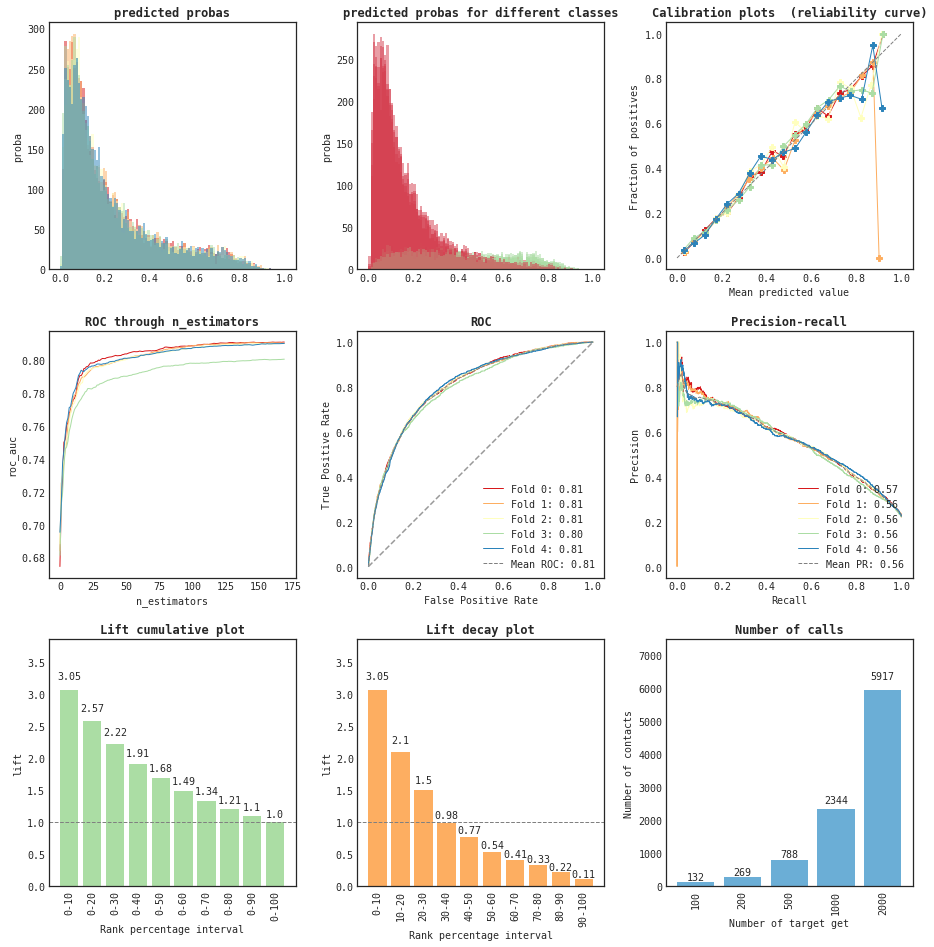

In [38]:
classifier = xgb.XGBClassifier(objective='binary:logistic',max_depth=6,n_estimators=170, learning_rate=0.05,max_delta_step=1,
                        min_child_weight=25, gamma=0.1, scale_pos_weight=1, colsample_bytree=0.85, subsample=0.85,colsample_bylevel=0.85,
                        nthread=6, seed=27)

results_cv_targeting, feature_importances,nb_calls_cv = xval.run_cross_validation_nine(fpf_dataset, classifier , feature_columns,'cifno','fpf_target','prob_of_all',5,.3,0,40)

In [23]:
nb_calls_cv

,nb_contacts,total_population,total_pos_targets,nb_pos_targets,pos_rate,Percentage_of_pos_targets_found,Percentage_of_Population,Lift
index,,,,,,,,
nb_contacts_100,128.4,5970.0,1312.6,100.0,0.780725,0.076200,0.021508,3.553564
nb_contacts_200,266.4,5970.0,1312.6,200.0,0.750876,0.152399,0.044623,3.416417
nb_contacts_500,789.2,5970.0,1312.6,500.0,0.633745,0.380998,0.132194,2.883136
nb_contacts_1000,2405.4,5970.0,1312.6,1000.0,0.415864,0.761996,0.402915,1.891628
nb_contacts_all,5870.0,5970.0,1312.6,1312.6,0.223618,1.000000,0.983250,1.017106
nb_contacts_2000,NaN,5970.0,1312.6,2000.0,NaN,1.523993,NaN,NaN


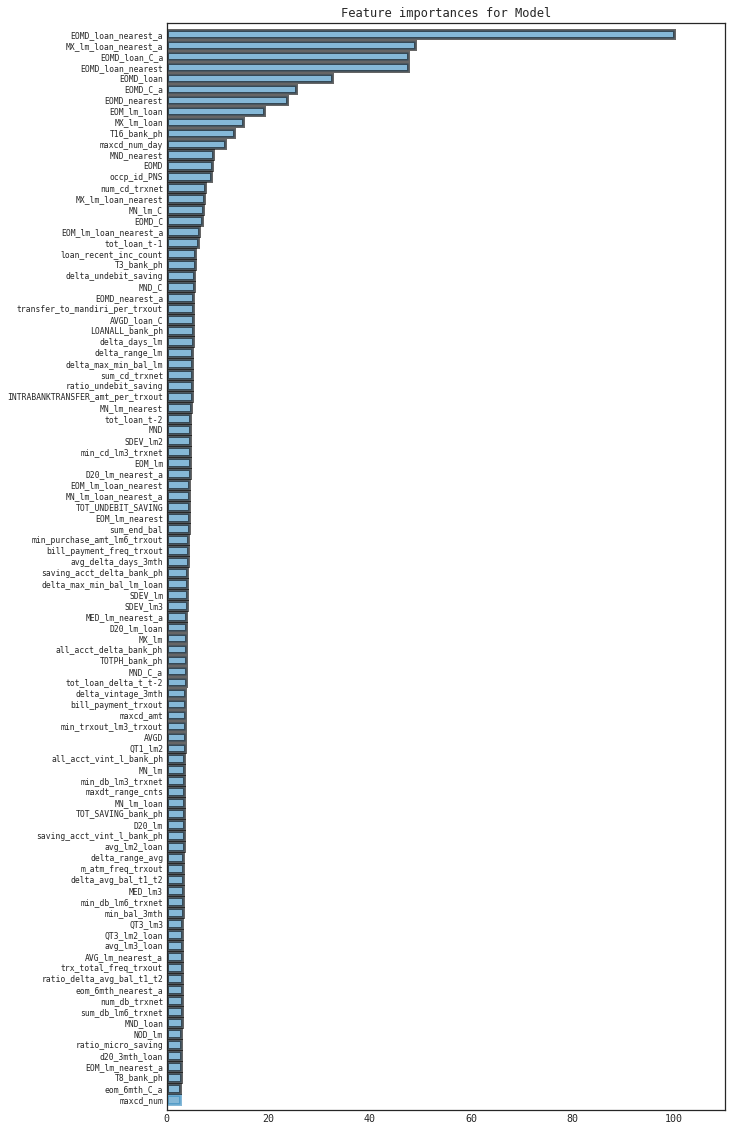

In [25]:
test_feat = feat_imp.feat_imp_xval_plot(feature_importances)

In [26]:
test_feat

,feature,mean,std,abs_imp,relative_imp
0,maxcd_num,5.430552,1.431732,5.430552,2.585908
1,eom_6mth_C_a,5.673971,0.964134,5.673971,2.701819
2,T8_bank_ph,5.750939,0.684356,5.750939,2.738470
3,EOM_lm_nearest_a,5.920819,0.941012,5.920819,2.819363
4,d20_3mth_loan,5.934707,0.401181,5.934707,2.825976
5,ratio_micro_saving,5.958856,1.381378,5.958856,2.837475
6,NOD_lm,6.047047,0.415671,6.047047,2.879470
7,MND_loan,6.186944,0.268905,6.186944,2.946086
8,sum_db_lm6_trxnet,6.202172,0.958413,6.202172,2.953337
9,num_db_trxnet,6.206285,0.484755,6.206285,2.955295


In [ ]:
feature_importances['abs_imp'] = feature_importances['mean'].apply(lambda x: abs(x))
feature_importances_sort = feature_importances.sort_values(by='abs_imp',ascending=False)
feature_importances_sort['relative_imp'] = 100.0 * (feature_importances_sort['abs_imp'] / feature_importances_sort['abs_imp'].max())

#feature_importances_sort.to_csv(FEAT_IMP_OUTPUT,index=False)
#features_df = feature_importances_sort.copy()

feature_importances_sort = feature_importances_sort[::-1].reset_index(drop=True)

#feature_importances_sort = feature_importances_sort.tail(50).reset_index(drop=True)

plt.figure(figsize=(10, 20))
plt.title("Feature importances for Model")
plt.barh(feature_importances_sort.index, feature_importances_sort['relative_imp'],
         color='#348ABD',align="center", lw='3', edgecolor='#348ABD', alpha=0.6)
plt.yticks(feature_importances_sort.index, feature_importances_sort['feature'], fontsize=8,)

plt.ylim([-1, feature_importances_sort.index.max()+1])
plt.xlim([0, feature_importances_sort['relative_imp'].max()*1.1])

plt.show()

In [37]:
fpf_dataset.head()

,cifno,fpf_target,EOMD_loan_nearest_a,EOMD_loan_C_a,EOMD_loan_nearest,EOMD_loan,EOMD_nearest,EOM_lm_loan_nearest_a,MX_lm_loan_nearest_a,EOM_lm_loan,...,QT1_lm2,avg_lm3_loan,MN_lm,maxcd_amt,MED_lm_nearest_a,avg_lm2_loan,num_db_trxnet,ratio_micro_saving,MN_lm_nearest,AVGD
0,1.000021e+09,0,4,1,4,119000.0,4,4,4,189000.0,...,163000.0,138000.0,164000.0,19800.0,4,164000.0,0.0,0.0,4,117000.0
1,1.000039e+09,1,0,0,4,983.0,4,0,3,983.0,...,1500.0,0.0,3600.0,3500.0,3,8040.0,0.0,1.0,4,3760.0
2,1.000143e+09,0,0,0,1,157.0,4,0,1,157.0,...,1130.0,186.0,1130.0,0.0,1,82.8,0.0,1.0,4,1230.0
3,1.000202e+09,0,4,1,4,411000.0,4,4,4,411000.0,...,243000.0,31400.0,406000.0,4480.0,4,414000.0,17.0,0.0,4,524000.0
4,1.000217e+09,0,4,1,4,9320.0,4,4,4,9320.0,...,1090.0,574.0,4090.0,3140.0,4,2130.0,10.0,0.0,4,5310.0


In [36]:
fpf_dataset.to_csv('C:\Users\liuleo\Documents\KT\Python_template\Classification\exa_dataset.csv', index=False, sep='|')

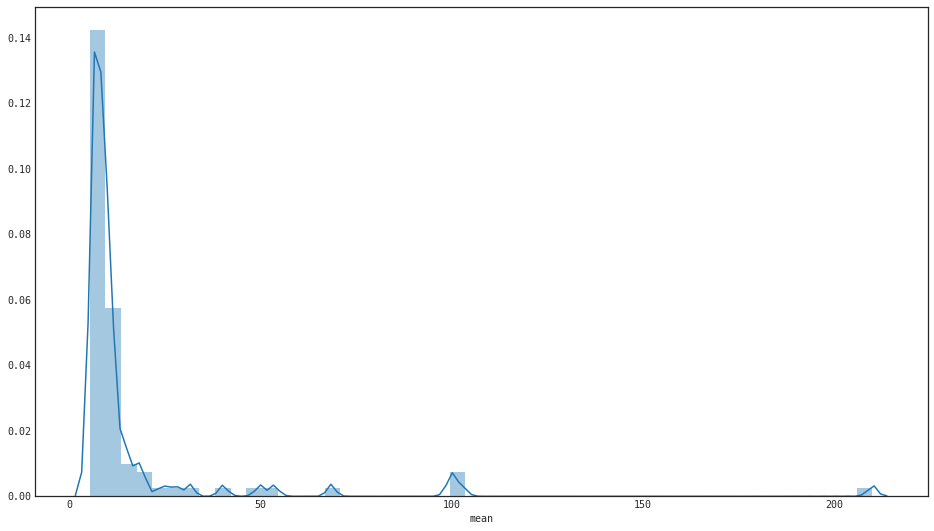

In [28]:
plt.figure(figsize=(16,9))
sns.distplot(test_feat['mean'])

In [29]:
np.histogram(test_feat['mean'],bins=50)

(array([57, 23,  4,  3,  1,  1,  1,  0,  1,  0,  1,  1,  0,  0,  0,  1,  0,
         0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1], dtype=int64),
 array([   5.43055167,    9.52205233,   13.613553  ,   17.70505366,
          21.79655433,   25.88805499,   29.97955566,   34.07105632,
          38.16255698,   42.25405765,   46.34555831,   50.43705898,
          54.52855964,   58.62006031,   62.71156097,   66.80306164,
          70.8945623 ,   74.98606297,   79.07756363,   83.1690643 ,
          87.26056496,   91.35206563,   95.44356629,   99.53506696,
         103.62656762,  107.71806829,  111.80956895,  115.90106962,
         119.99257028,  124.08407095,  128.17557161,  132.26707228,
         136.35857294,  140.4500736 ,  144.54157427,  148.63307493,
         152.7245756 ,  156.81607626,  160.90757693,  164.99907759,
         169.09057826,  173.18207892,  177.27357959,  181.36508025,
         185.

In [ ]:
TOP_FEATS = features_df.head(153)['feature'].values.tolist()
TOP_FEATS

# Create model with all data

In [ ]:
fpf_dataset.shape

In [ ]:
IDS = ['cifno']
ALL_TARGETS = ['fpf_target']

In [ ]:
TOP_200_FEAT = classifier.booster().feature_names
print len(TOP_200_FEAT)

In [ ]:
TOP_200_FEAT 

In [ ]:
feature_columns = [col for col in TOP_200_FEAT]
feature_columns = np.concatenate([IDS, feature_columns])
print len(feature_columns)

In [ ]:
X_train = fpf_dataset.drop(ALL_TARGETS, axis=1)

In [ ]:
print(ALL_TARGETS)

for target in ALL_TARGETS:
    print("target proportion %s"%target)
    print(fpf_dataset[target].mean())
    print(fpf_dataset[target].mean())

In [ ]:
print('Start TARGETING MODELA CREATION WITH XGB')

target = 'fpf_target'

clf = xgb.XGBClassifier(objective='binary:logistic',max_depth=6,n_estimators=200, learning_rate=0.05,max_delta_step=1,
                        min_child_weight=25, gamma=0.1, scale_pos_weight=1, colsample_bytree=0.85, subsample=0.85,colsample_bylevel=0.85,
                        nthread=6, seed=27)

#clfbag_targeting = BaggingClassifier(clf, n_estimators=10, max_samples=0.9, max_features=0.9)

train_X = X_train[feature_columns].drop(['cifno'], axis=1).reset_index(drop=True)

y_train = np.array(fpf_dataset[target].astype(np.uint8))

clf.fit(train_X, y_train)




In [ ]:
MODEL_PKL_OUTPUT

In [ ]:
print('STROING MODELA TARGETING MODEL TO PICKLE')
joblib.dump(clf,MODEL_PKL_OUTPUT, compress=1)
print('DONE!')

In [ ]:
feature_importances_data = []
features = feature_columns
for feature_name, feature_importance in get_importance(clf.booster(), 'gain').iteritems():
    feature_importances_data.append({
       'feature': feature_name,
       'importance': feature_importance
    })
    
feature_importances = pd.DataFrame(feature_importances_data)
feature_importances_sort = feature_importances.sort_values(by='importance',ascending=False)
feature_importances_top50 = feature_importances_sort[:50][::-1].reset_index(drop=True)

In [ ]:
feature_importances['abs_imp'] = feature_importances['importance'].apply(lambda x: abs(x))
feature_importances_sort = feature_importances.sort_values(by='abs_imp',ascending=False)
feature_importances_sort['relative_imp'] = 100.0 * (feature_importances_sort['abs_imp'] / feature_importances_sort['abs_imp'].max())
features_df = feature_importances_sort.copy()

feature_importances_sort = feature_importances_sort[::-1].reset_index(drop=True)
feature_importances_sort = feature_importances_sort.tail(50).reset_index(drop=True)

plt.figure(figsize=(10, 20))
plt.title("Feature importances for Model")
plt.barh(feature_importances_sort.index, feature_importances_sort['relative_imp'],
         color='#348ABD', align="center", lw='3', edgecolor='#348ABD', alpha=0.6)
plt.yticks(feature_importances_sort.index, feature_importances_sort['feature'], fontsize=12,)
plt.ylim([-1, feature_importances_sort.index.max()+1])
plt.xlim([0, feature_importances_sort['relative_imp'].max()*1.1])
plt.show()

In [ ]:
plt.figure(figsize=(16,9))
sns.distplot(features_df['importance'])

In [ ]:
np.histogram(feature_importances_top50['importance'],bins=50)

# FPF Model Apply

In [ ]:
APPLY_DATASET

In [ ]:
%time fpf_apply_dataset = pd.read_csv(APPLY_DATASET,sep='|')

In [ ]:
#fpf_apply_dataset = pd.concat([fpf_1702, fpf_1703]).reset_index(drop=True)
fpf_apply_dataset = fpf_1705.copy()

In [ ]:
print fpf_apply_dataset.cifno.nunique()
print fpf_apply_dataset.shape
fpf_apply_dataset = fpf_apply_dataset[fpf_apply_dataset['AVGD']>=1000000].reset_index(drop=True)
print fpf_apply_dataset.cifno.nunique()
print fpf_apply_dataset.shape

In [ ]:
UINT8_COLS = ['WEST','nb_accts_sd','health_freq_db_edc','fpf_target','leisure_hobby_freq_db_edc','luxury_freq_db_edc',
              'household_freq_db_edc','offus_freq_db_edc','services_freq_db_edc','daily_life_freq_db_edc','vehicle_freq_db_edc',
              'T1_bank_ph','T2_bank_ph','T3_bank_ph','T4_bank_ph','T5_bank_ph','T6_bank_ph','T7_bank_ph','T8_bank_ph',
              'T9_bank_ph','T10_bank_ph','T11_bank_ph','T12_bank_ph','T13_bank_ph','T14_bank_ph','T15_bank_ph','T16_bank_ph',
              'T17_bank_ph','T18_bank_ph','TOTPH_bank_ph','TOT_SAVING_bank_ph',
              'CREDITCARD_freq_trxout','EDUCATION_freq_trxout','INSURANCE_freq_trxout','INTERBANKTRANSFER_freq_trxout',
              'INTRABANKTRANSFER_freq_trxout','LEASING_freq_trxout','MEDIA_freq_trxout','PDAM_freq_trxout',
              'PERSONALLOAN_freq_trxout','PLN_freq_trxout','PULSA_freq_trxout','TICKET_freq_trxout','TVCABLE_freq_trxout',
              'ZAKAT_freq_trxout','TSO_AGE'] 

INT8_COLS = ['delta_days_lm', 'max_vintage_3mth', 'max_vintage_6mth', 'min_vintage_3mth', 'min_vintage_6mth', 'delta_vintage_3mth',
            'delta_vintage_6mth', 'maxdt_range_cnts', 'mindt_range_cnts','age_tier','year_addr','year_rel','year_work','depend_nb',
            'nb_alop_cc','nb_classic_cc','nb_gold_cc','nb_platinum_cc','nb_signature_cc','total_nb_cc','nb_prioritas_dc',
            'nb_silver_dc','nb_gold_dc','nb_platinum_dc','nb_others_dc','total_nb_dc','travel_freq_db_edc','maxdb_num_day',
            'maxdb_num_uni_weekday','maxcd_num_uni_weekday','maxdb_day_1_10','maxdb_day_11_20','maxdb_day_21_up','maxcd_num_day',
             'maxcd_day_1_10','maxcd_day_11_20','maxcd_day_21_up','delta_range_lm','TSO_LOCATION_01.BBD', 
             'TSO_CATEGORY_01.TOP GUN','TSO_CATEGORY_02.STRIKER','TSO_CATEGORY_03.PLAYMAKER','TSO_CATEGORY_04.DEFENDER',
             'TSO_GENDER_02.MALE','TSO_EDUCATION_01.S2','TSO_EDUCATION_02.S1','TSO_EDUCATION_03.AKADEMI','TSO_EDUCATION_04.SLTA',
             'TSO_MARITAL_STATUS_02.MAR'
            ]

INT16_COLS = ['sum_freq_lm3_db_edc','sum_freq_lm6_db_edc','freq_lm_lm3_diff_db_edc','freq_lm3_lm6_diff_db_edc',
              'max_freq_lm3_db_edc','min_freq_lm3_db_edc', 'maxcd_num','maxdb_num','saving_acct_vint_l_bank_ph',
              'saving_acct_vint_f_bank_ph','saving_acct_delta_bank_ph', 'all_acct_vint_l_bank_ph','all_acct_vint_f_bank_ph',
              'all_acct_delta_bank_ph']

UINT16_COLS = ['ib_freq_trxout','mb_freq_trxout','branch_freq_trxout','nm_atm_freq_trxout','m_atm_freq_trxout','mcm_freq_trxout',
              'chnl_others_freq_trxout','sum_purchase_freq_trxout','date_org_vintage']

INT64_COLS = ['max_bal_3mth', 'max_bal_6mth', 'min_bal_3mth', 'min_bal_6mth', 'eom_3mth', 'eom_6mth', 'sum_end_bal', 'MED_lm', 
              'QT1_lm', 'QT3_lm', 'D20_lm', 'EOM_lm', 'NOD_lm','MED_lm2','QT1_lm2', 'QT3_lm2',
              'MED_lm3', 'QT1_lm3', 'QT3_lm3', 'one_max_delta_bal_3mth','d20_3mth','vol_income']

INT8_COLS_FLAG = [col for col in fpf_apply_dataset if 'flag' in col]

DUMMIFIED_COLS = ['intuser_fg', 'mbluser_fg', 'prior_fg', 'rsdnt_fg', 'weekday_','gender_id','occp_id','houstyp_id','marital_id',
                  'cusedu_id','empinds_id','CALL_START_hour_']

INT8_COLS_DUM = [col for col in fpf_apply_dataset for dum in DUMMIFIED_COLS if dum in col]

INT8_COLS_ALL = INT8_COLS + INT8_COLS_FLAG + INT8_COLS_DUM

print 'change data types to reduce memory usage'
for col in UINT8_COLS:
    fpf_apply_dataset[col] = fpf_apply_dataset[col].astype(np.uint8)
    
for col in INT8_COLS_ALL:
    fpf_apply_dataset[col] = fpf_apply_dataset[col].astype(np.int8)
    
for col in INT16_COLS:
    fpf_apply_dataset[col] = fpf_apply_dataset[col].astype(np.int16)

for col in UINT16_COLS:
    fpf_apply_dataset[col] = fpf_apply_dataset[col].astype(np.uint16)

for col in INT64_COLS:
    fpf_apply_dataset[col] = fpf_apply_dataset[col].astype(np.int64)

# Start applying

In [ ]:
%time fpf_apply_dataset = process_numeric(fpf_apply_dataset)
%time fpf_apply_dataset = process_float(fpf_apply_dataset)

In [ ]:
MODEL_PKL_OUTPUT

In [ ]:
clf = joblib.load(MODEL_PKL_OUTPUT)

In [ ]:
clf

In [ ]:
TOP_200_FEAT = clf.booster().feature_names
print len(TOP_200_FEAT)

In [ ]:
TOP_200_FEAT

In [ ]:
IDS = ['cifno']
ALL_TARGETS = ['fpf_target']

feature_columns = [col for col in TOP_200_FEAT]
feature_columns = np.concatenate([IDS, feature_columns])
print len(feature_columns)

In [ ]:
print(ALL_TARGETS)

for target in ALL_TARGETS:
    print("target proportion %s"%target)
    print(fpf_apply_dataset[target].sum())
    print(fpf_apply_dataset[target].mean())

In [ ]:
fpf_apply_dataset.shape

# XGB Apply Stack Split(1702,03)

In [ ]:
temp = fpf_apply_dataset[['cifno', 'fpf_target']].copy()
results_cv_targeting = pd.DataFrame([], columns=['cifno', 'fpf_target', 'proba_fpf_target'])
nb_calls_cv = pd.DataFrame([], columns=['nb_contacts', 'total_population', 'total_X_sellers', 'nb_Xsellers',
                                            'Xsell_rate','Percentage_of_Xseller_found', 'Percentage_of_Population', 'Lift'])

print('Start Model applying')

target='fpf_target'


test_X = fpf_apply_dataset[feature_columns].drop(['cifno'], axis=1).reset_index(drop=True)

y_test = np.array(fpf_apply_dataset[target].astype(np.uint8))

_probas = clf.predict_proba(test_X)
#_predict = clf.predict(test_X)

print("ROC AUC SCORE\t:\t" + str(roc_auc_score(y_test, _probas[:, 1])))
print("ACCURACY SCORE\t:\t" + str(accuracy_score(y_test, _probas[:, 1].astype(np.uint8))))

##add feature importance
#feat_imp = pd.Series(clf.booster().get_fscore()).sort_values(ascending=True)

proba = _probas[:, 1]

cols = ['proba_' + target]

proba_df = pd.DataFrame(data=proba, index=fpf_apply_dataset[feature_columns].index, columns=cols)
#results_test = pd.concat([results_test, proba_df], axis=1)

temp = temp.join(proba_df, how='left')
results_cv_targeting = results_cv_targeting.append(temp)

# Calculate nb calls to make
nb_calls = temp[['fpf_target', 'proba_fpf_target']].copy()
nb_calls = nb_calls.sort_values(by='proba_fpf_target', ascending=False).reset_index(drop=True)
nb_calls['cum_Xsellers'] = np.cumsum(nb_calls.fpf_target)
nb_calls = nb_calls.reset_index(drop=False)
nb_calls = nb_calls.rename(columns={'index': 'rank'})
test_results = nb_calls.copy()
nb_calls['nb_calls_100'] = nb_calls.loc[nb_calls.cum_Xsellers == 100, 'rank'].min()
nb_calls['nb_calls_200'] = nb_calls.loc[nb_calls.cum_Xsellers == 200, 'rank'].min()
nb_calls['nb_calls_928'] = nb_calls.loc[nb_calls.cum_Xsellers == 928, 'rank'].min()
nb_calls['nb_calls_1856'] = nb_calls.loc[nb_calls.cum_Xsellers == 1856, 'rank'].min()
nb_calls['nb_calls_2784'] = nb_calls.loc[nb_calls.cum_Xsellers == 2784, 'rank'].min()
#nb_calls['nb_calls_2000'] = nb_calls.loc[nb_calls.cum_Xsellers == 2000, 'rank'].min()
#nb_calls['nb_calls_3000'] = nb_calls.loc[nb_calls.cum_Xsellers == 3000, 'rank'].min()
nb_calls['nb_calls_all'] = nb_calls.loc[nb_calls.cum_Xsellers == nb_calls.cum_Xsellers.max(), 'rank'].min()
nb_calls = nb_calls[
    ['nb_calls_100', 'nb_calls_200', 'nb_calls_928', 'nb_calls_1856','nb_calls_2784',
     'nb_calls_all']].min()
nb_calls = pd.DataFrame(nb_calls, columns=['nb_contacts'])
nb_calls['total_population'] = temp.shape[0]
nb_calls['total_X_sellers'] = temp.fpf_target.sum()
nb_calls['nb_Xsellers'] = [100, 200, 928, 1856,2784, temp.fpf_target.sum()]
nb_calls['Xsell_rate'] = nb_calls.nb_Xsellers / nb_calls.nb_contacts
nb_calls['Percentage_of_Xseller_found'] = nb_calls.nb_Xsellers / nb_calls.total_X_sellers
nb_calls['Percentage_of_Population'] = nb_calls.nb_contacts / nb_calls.total_population
nb_calls['Lift'] = nb_calls.Percentage_of_Xseller_found / nb_calls.Percentage_of_Population

nb_calls_cv = nb_calls_cv.append(nb_calls)


nb_calls_cv = nb_calls_cv.reset_index().groupby('index').mean().sort_values(by='nb_Xsellers')
results_cv_targeting = results_cv_targeting.reset_index(drop=True)

nb_calls_cv

In [ ]:
# Plot calibration plots
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, proba, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.grid(True)


In [ ]:
print fraction_of_positives
print mean_predicted_value

In [ ]:
#proba distribution for all customers

plt.hist(results_cv_targeting.proba_fpf_target, range=(0, 1), bins=100, label="proba distribution", histtype="step", lw=2)
plt.xlabel("Mean predicted value")
plt.ylabel("Count")
#plt.legend(loc="upper right", ncol=2)
plt.grid(True)

plt.show()

# ICE PLOT

In [ ]:
from iceplot import ice

In [ ]:
features = clf.booster().feature_names
print len(features)

In [ ]:
train_data = train_X[features]

In [ ]:
train_data.EOMD_loan

In [ ]:
%time EOMD_loan = ice.ice(clf, train_data[features], 'EOMD_loan', 'numeric', center=True, num_grid_points=10)
ice.ice_random_plot(EOMD_loan, 'EOMD_loan', frac_to_plot=1000, plot_pdp=True, figsize=(16, 9))

In [ ]:
%time EOM_lm_loan_C = ice.ice(clf, train_data[features], 'EOM_lm_loan_C', 'binary', center=True)
ice.ice_random_plot(EOM_lm_loan_C, 'EOM_lm_loan_C', frac_to_plot=5000, plot_pdp=True, figsize=(16, 9))

In [ ]:
%time ratio_micro_saving = ice.ice(clf, train_data[features], 'ratio_micro_saving', 'numeric', center=True, num_grid_points=10)
ice.ice_random_plot(ratio_micro_saving, 'ratio_micro_saving', frac_to_plot=1000, plot_pdp=True, figsize=(16, 9))

In [ ]:
%time LOANALL_bank_ph = ice.ice(clf, train_data[features], 'LOANALL_bank_ph', 'numeric', center=True, num_grid_points=10)
ice.ice_random_plot(LOANALL_bank_ph, 'LOANALL_bank_ph', frac_to_plot=1000, plot_pdp=True, figsize=(16, 9))

In [ ]:
%time EOM_lm_loan = ice.ice(clf, train_data[features], 'EOM_lm_loan', 'numeric', center=True, num_grid_points=10)
ice.ice_random_plot(EOM_lm_loan, 'EOM_lm_loan', frac_to_plot=1000, plot_pdp=True, figsize=(16, 9))

In [ ]:
%time TOT_UNDEBIT_SAVING = ice.ice(clf, train_data[features], 'TOT_UNDEBIT_SAVING', 'numeric', center=True, num_grid_points=10)
ice.ice_random_plot(TOT_UNDEBIT_SAVING, 'TOT_UNDEBIT_SAVING', frac_to_plot=1000, plot_pdp=True, figsize=(16, 9))

In [ ]:
%time loan_to_debit = ice.ice(clf, train_data[features], 'loan_to_debit', 'numeric', center=True, num_grid_points=10)
ice.ice_random_plot(loan_to_debit, 'loan_to_debit', frac_to_plot=1000, plot_pdp=True, figsize=(16, 9))

In [ ]:
%time maxcd_num_uni_weekday = ice.ice(clf, train_data[features], 'maxcd_num_uni_weekday', 'numeric', center=True, num_grid_points=10)
ice.ice_random_plot(maxcd_num_uni_weekday, 'maxcd_num_uni_weekday', frac_to_plot=1000, plot_pdp=True, figsize=(16, 9))

In [ ]:
%time maxcd_num = ice.ice(clf, train_data[features], 'maxcd_num', 'numeric', center=True, num_grid_points=10)
ice.ice_random_plot(maxcd_num, 'maxcd_num', frac_to_plot=1000, plot_pdp=True, figsize=(16, 9))

In [ ]:
%time maxcd_num_day = ice.ice(clf, train_data[features], 'maxcd_num_day', 'numeric', center=True, num_grid_points=10)
ice.ice_random_plot(maxcd_num_day, 'maxcd_num_day', frac_to_plot=1000, plot_pdp=True, figsize=(16, 9))

In [ ]:
#government employee
%time occp_id_PNS = ice.ice(clf, train_data[features], 'occp_id_PNS', 'binary', center=True)
ice.ice_random_plot(occp_id_PNS, 'occp_id_PNS', frac_to_plot=1000, plot_pdp=True, figsize=(16, 9))